# Collocation

<a target="_blank" href="https://colab.research.google.com/github/arthurrichards77/smply/blob/master/collocation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

The collocation approach solves nonlinear trajectory optimization essentially by curve-fitting.  The decision variables are a the states and controls at a set of _collocation points_.  These are enough to determine polynomials that interpolate the collocation points, so the derivative values of these quantities are also known.  An analytical model of the dynamics is used to enforce the differential constraints~$\dot{x}(t) = f(x(t),u(t))$ at the collocation points.  This ensures the solution satisfies, approximately, the differential equation of the dynamics, without the overhead of numerical integration (see Shooting Method).

In [467]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [468]:
s0 = (0,0,0.5*np.pi)
sf = (0.7,0.7,-0.5*np.pi)

In [469]:
colloc_dist = np.array([0,0.15,0.35,0.65,0.85,1.0])
colloc_dist = np.array([0,0.25,0.75,1.0])
num_colloc = len(colloc_dist)

In [470]:
num_colloc = 18
colloc_dist = 0.5 - 0.5*np.cos([(2*k+1)*np.pi/(2*num_colloc) for k in range(num_colloc)])
colloc_dist[0] = 0.0
colloc_dist[-1] = 1.0
colloc_dist

array([0.        , 0.01703709, 0.04684611, 0.09042398, 0.14644661,
       0.21321178, 0.28869087, 0.37059048, 0.45642213, 0.54357787,
       0.62940952, 0.71130913, 0.78678822, 0.85355339, 0.90957602,
       0.95315389, 0.98296291, 1.        ])

In [471]:
coeffs_to_colloc = np.array([colloc_dist**i for i in range(num_colloc)]).T
coeffs_to_colloc

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.70370869e-02, 2.90262329e-04, 4.94522450e-06,
        8.42522194e-08, 1.43541238e-09, 2.44552454e-11, 4.16646140e-13,
        7.09843647e-15, 1.20936679e-16, 2.06040870e-18, 3.51033619e-20,
        5.98059026e-22, 1.01891836e-23, 1.73594006e-25, 2.95753615e-27,
        5.03878003e-29, 8.58461330e-31],
       [1.00000000e+00, 4.68461065e-02, 2.19455769e-03, 1.02806483e-04,
        4.81608347e-06, 2.25614759e-07, 1.05691730e-08, 4.95124605e-10,
        2.31946599e-11, 1.08657951e-12, 5.09020194e-14, 2.38456142e-15,
        1.11707418e-16, 5.23305761e-18, 2.45148374e-19, 1.14842468e-20,
        5.37992250e-22, 2.52028422e-23],
       [1.000

In [472]:
coeffs_to_colloc_deriv = np.vstack((colloc_dist*0,  np.array([i*colloc_dist**(i-1) for i in range(1,num_colloc)]))).T
coeffs_to_colloc_deriv

array([[0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 3.40741737e-02, 8.70786986e-04,
        1.97808980e-05, 4.21261097e-07, 8.61247427e-09, 1.71186718e-10,
        3.33316912e-12, 6.38859282e-14, 1.20936679e-15, 2.26644957e-17,
        4.21240343e-19, 7.77476734e-21, 1.42648570e-22, 2.60391008e-24,
        4.73205784e-26, 8.56592605e-28],
       [0.00000000e+00, 1.00000000e+00, 9.36922130e-02, 6.58367308e-03,
        4.11225933e-04, 2.40804173e-05, 1.35368855e-06, 7.39842111e-08,
        3.96099684e-09, 2.08751940e-10, 1.08657951e-11, 5.59922214e-13,
        2.86147371e-14, 1.45219644e-15, 7.32628066e-17, 3.67722561e-18,
        1.83747949e-19, 9.14586825e-21],
       [0.000

In [473]:
colloc_to_colloc_deriv = coeffs_to_colloc_deriv@np.linalg.inv(coeffs_to_colloc)
colloc_to_colloc_deriv

array([[-1.22415452e+02,  1.97012901e+02, -1.26346224e+02,
         9.06404594e+01, -6.95526364e+01,  5.55599227e+01,
        -4.54943881e+01,  3.78134290e+01, -3.16799340e+01,
         2.66003157e+01, -2.22638001e+01,  1.84637674e+01,
        -1.50555794e+01,  1.19327605e+01, -9.01031952e+00,
         6.20934924e+00, -3.41446336e+00,  9.99927640e-01],
       [-1.74869804e+01, -2.17963714e+01,  5.91558488e+01,
        -3.32733734e+01,  2.34496028e+01, -1.79903382e+01,
         1.44039339e+01, -1.18084070e+01,  9.80418771e+00,
        -8.18128167e+00,  6.81743742e+00, -5.63571944e+00,
         4.58466930e+00, -3.62742390e+00,  2.73562033e+00,
        -1.88352176e+00,  1.03516342e+00, -3.03057586e-01],
       [ 3.60656754e+00, -1.90242874e+01, -5.97563657e+00,
         3.17761396e+01, -1.72778388e+01,  1.20299222e+01,
        -9.17499962e+00,  7.31282893e+00, -5.96430749e+00,
         4.91774865e+00, -4.06373595e+00,  3.33921377e+00,
        -2.70453404e+00,  2.13294742e+00, -1.60483122e

In [474]:
z = np.hstack((np.linspace(s0[0],sf[0],num_colloc),
               np.linspace(s0[1],sf[1],num_colloc),
               np.linspace(s0[2],sf[2],num_colloc),
               np.ones_like(colloc_dist)*1.8,
               np.zeros_like(colloc_dist),
               5.0))
z

array([ 0.        ,  0.04117647,  0.08235294,  0.12352941,  0.16470588,
        0.20588235,  0.24705882,  0.28823529,  0.32941176,  0.37058824,
        0.41176471,  0.45294118,  0.49411765,  0.53529412,  0.57647059,
        0.61764706,  0.65882353,  0.7       ,  0.        ,  0.04117647,
        0.08235294,  0.12352941,  0.16470588,  0.20588235,  0.24705882,
        0.28823529,  0.32941176,  0.37058824,  0.41176471,  0.45294118,
        0.49411765,  0.53529412,  0.57647059,  0.61764706,  0.65882353,
        0.7       ,  1.57079633,  1.38599676,  1.20119719,  1.01639762,
        0.83159806,  0.64679849,  0.46199892,  0.27719935,  0.09239978,
       -0.09239978, -0.27719935, -0.46199892, -0.64679849, -0.83159806,
       -1.01639762, -1.20119719, -1.38599676, -1.57079633,  1.8       ,
        1.8       ,  1.8       ,  1.8       ,  1.8       ,  1.8       ,
        1.8       ,  1.8       ,  1.8       ,  1.8       ,  1.8       ,
        1.8       ,  1.8       ,  1.8       ,  1.8       ,  1.8 

In [475]:
def extract_components(z):
    x = z[0:num_colloc]
    y = z[num_colloc:(2*num_colloc)]
    h = z[(2*num_colloc):(3*num_colloc)]
    v = z[(3*num_colloc):(4*num_colloc)]
    k = z[(4*num_colloc):(5*num_colloc)]
    T = z[(5*num_colloc)]
    return x,y,h,v,k,T

In [476]:
def dynamics_constraints(z):
    x,y,h,v,k,T = extract_components(z)
    xdot_err = (1/T)*colloc_to_colloc_deriv@x - v*np.sin(h) # x-dot = v sin h
    ydot_err = (1/T)*colloc_to_colloc_deriv@y - v*np.cos(h) # y-dot = v cos h
    hdot_err = (1/T)*colloc_to_colloc_deriv@h - v*k # h-dot = v k
    return np.hstack((xdot_err,ydot_err,hdot_err))

dynamics_constraints(z)

array([-1.15923285, -1.40200704, -1.45736318, -1.36485309, -1.197282  ,
       -0.9692602 , -0.69836133, -0.39481035, -0.07137421,  0.26078951,
        0.59037086,  0.9062919 ,  1.20022225,  1.46315292,  1.69593204,
        1.89954264,  2.13668818,  2.44076051,  0.64076715,  0.03659541,
       -0.42914817, -0.78204014, -1.07971811, -1.32094887, -1.50732622,
       -1.63350312, -1.69761268, -1.69761506, -1.63350868, -1.50733106,
       -1.32095111, -1.07971529, -0.7820367 , -0.42914237,  0.03658747,
        0.64076051, -2.87574489, -1.64864193, -0.99225614, -0.74296268,
       -0.59663448, -0.51829647, -0.4666034 , -0.43883635, -0.42503848,
       -0.42503388, -0.43882587, -0.46659277, -0.51829257, -0.59663735,
       -0.74295885, -0.99224349, -1.64863595, -2.87573099])

In [477]:
test_v = 0.5
test_h = np.pi/12
test_T = 16.0

test_x = test_v*test_T*np.sin(test_h)*colloc_dist
test_y = test_v*test_T*np.cos(test_h)*colloc_dist

dyn_test_z = np.hstack((test_x,
                        test_y,
                        np.ones_like(colloc_dist)*test_h,
                        np.ones_like(colloc_dist)*test_v,
                        np.zeros_like(colloc_dist),
                        test_T))

dynamics_constraints(dyn_test_z)

array([ 1.01880732e-05,  4.58600910e-06, -2.32903868e-06, -7.33854998e-06,
       -7.98741105e-06, -4.62963290e-06,  1.41244389e-07,  3.38867794e-06,
        3.59950555e-06,  1.20128216e-06, -2.25937178e-06, -4.82826767e-06,
       -6.76477576e-06, -5.21934005e-06, -4.44584655e-06,  1.61449710e-06,
       -2.69489312e-06,  3.32451080e-06,  3.80224069e-05,  1.71152190e-05,
       -8.69209067e-06, -2.73878414e-05, -2.98094239e-05, -1.72780252e-05,
        5.27131235e-07,  1.26467182e-05,  1.34335376e-05,  4.48324604e-06,
       -8.43209029e-06, -1.80193403e-05, -2.52464868e-05, -1.94788422e-05,
       -1.65921252e-05,  6.02538520e-06, -1.00574780e-05,  1.24072432e-05,
        5.90521110e-07, -1.82220912e-07, -1.08102398e-06, -1.61360135e-06,
       -1.45168801e-06, -7.20340459e-07,  1.34088989e-07,  6.71325114e-07,
        7.18870185e-07,  4.02664348e-07, -8.25979565e-08, -4.44554755e-07,
       -1.04004097e-06, -9.42019366e-07, -6.08989039e-07,  9.31821693e-07,
       -1.72590578e-06, -

In [478]:
def boundary_constraints(z):
    init_err = np.array([s0[i] - z[i*num_colloc] for i in range(len(s0))])
    term_err = np.array([sf[i] - z[num_colloc + i*num_colloc - 1] for i in range(len(sf))])
    return np.hstack((init_err,term_err))

boundary_constraints(z)

array([0., 0., 0., 0., 0., 0.])

In [479]:
bc_test_z = np.hstack((np.linspace(s0[0],sf[0],num_colloc),
                    np.linspace(s0[1],sf[1],num_colloc),
                    np.linspace(s0[2],sf[2],num_colloc),
                    np.ones_like(colloc_dist),
                    np.zeros_like(colloc_dist),
                    5.0))

boundary_constraints(bc_test_z)

array([0., 0., 0., 0., 0., 0.])

In [480]:
vmax = 1.0
vmin = 0.1
kmax = 6.0

bounds = [(-1,1)]*2*num_colloc + [(-2*np.pi,2*np.pi)]*num_colloc + [(vmin,vmax)]*num_colloc + [(-kmax,kmax)]*num_colloc + [(0.001,100.0)]
bounds

[(-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.28318

In [481]:
def all_eq_constraints(z):
    return np.hstack((dynamics_constraints(z),boundary_constraints(z)))

all_eq_constraints(z)

array([-1.15923285, -1.40200704, -1.45736318, -1.36485309, -1.197282  ,
       -0.9692602 , -0.69836133, -0.39481035, -0.07137421,  0.26078951,
        0.59037086,  0.9062919 ,  1.20022225,  1.46315292,  1.69593204,
        1.89954264,  2.13668818,  2.44076051,  0.64076715,  0.03659541,
       -0.42914817, -0.78204014, -1.07971811, -1.32094887, -1.50732622,
       -1.63350312, -1.69761268, -1.69761506, -1.63350868, -1.50733106,
       -1.32095111, -1.07971529, -0.7820367 , -0.42914237,  0.03658747,
        0.64076051, -2.87574489, -1.64864193, -0.99225614, -0.74296268,
       -0.59663448, -0.51829647, -0.4666034 , -0.43883635, -0.42503848,
       -0.42503388, -0.43882587, -0.46659277, -0.51829257, -0.59663735,
       -0.74295885, -0.99224349, -1.64863595, -2.87573099,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [482]:
constraints = [{'type':'eq','fun':all_eq_constraints}]

In [483]:
def cost(z):
    return(z[-1])

In [484]:
res = minimize(cost,bc_test_z,method='SLSQP',bounds=bounds,constraints=constraints,options={'maxiter':1000})
res

C:\Users\aeagr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
C:\Users\aeagr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
C:\Users\aeagr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.316309346794463
       x: [-2.943e-20  2.236e-02 ... -6.000e+00  1.316e+00]
     nit: 102
     jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
    nfev: 9389
    njev: 102

In [485]:
x,y,h,v,k,T = extract_components(res.x)

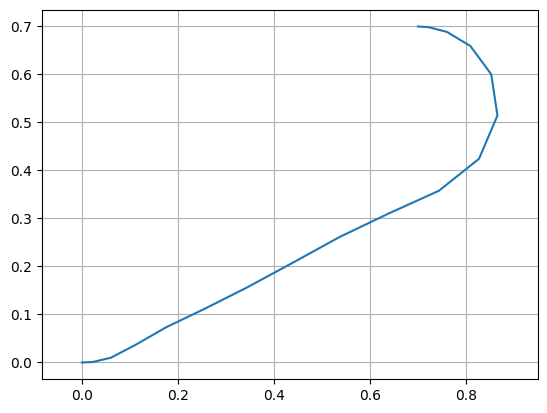

In [486]:
plt.plot(x,y)
plt.axis('equal')
plt.grid('on')
plt.show()

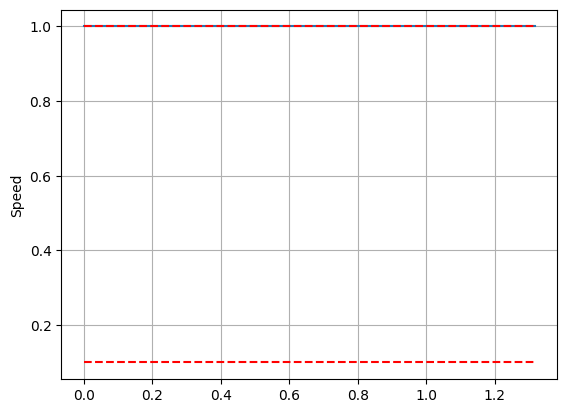

In [487]:
plt.plot(T*colloc_dist, v)
plt.plot([0,T], [vmax,vmax],'r--')
plt.plot([0,T], [vmin,vmin],'r--')
plt.grid('on')
plt.ylabel('Speed')
plt.show()

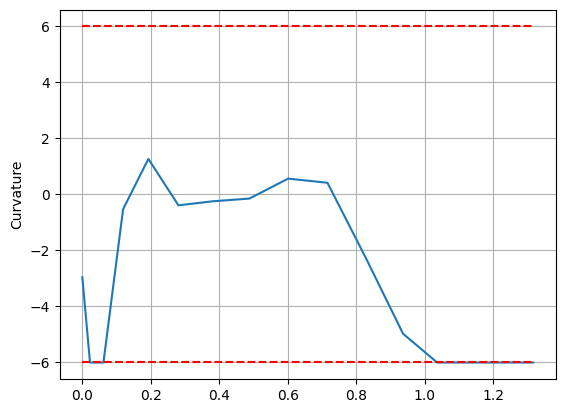

In [488]:
plt.plot(T*colloc_dist,k)
plt.plot([0,T], [kmax,kmax],'r--')
plt.plot([0,T], [-kmax,-kmax],'r--')
plt.grid('on')
plt.ylabel('Curvature')
plt.show()

In [489]:
eval_dist = np.linspace(0,1,100)

In [490]:
coeffs_to_eval = np.array([eval_dist**i for i in range(len(colloc_dist))]).T
coeffs_to_eval

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.01010101e-02, 1.02030405e-04, ...,
        1.16271180e-30, 1.17445637e-32, 1.18631956e-34],
       [1.00000000e+00, 2.02020202e-02, 4.08121620e-04, ...,
        3.80997404e-26, 7.69691724e-28, 1.55493278e-29],
       ...,
       [1.00000000e+00, 9.79797980e-01, 9.60004081e-01, ...,
        7.36288632e-01, 7.21414114e-01, 7.06840091e-01],
       [1.00000000e+00, 9.89898990e-01, 9.79900010e-01, ...,
        8.58743013e-01, 8.50068841e-01, 8.41482287e-01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [491]:
colloc_to_eval = coeffs_to_eval@np.linalg.inv(coeffs_to_colloc)

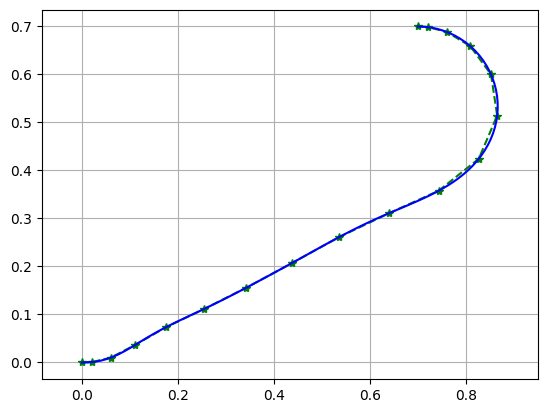

In [492]:
plt.plot(x,y,'*g--')
plt.plot(colloc_to_eval@x,
         colloc_to_eval@y,'b-')
plt.axis('equal')
plt.grid('on')
plt.show()

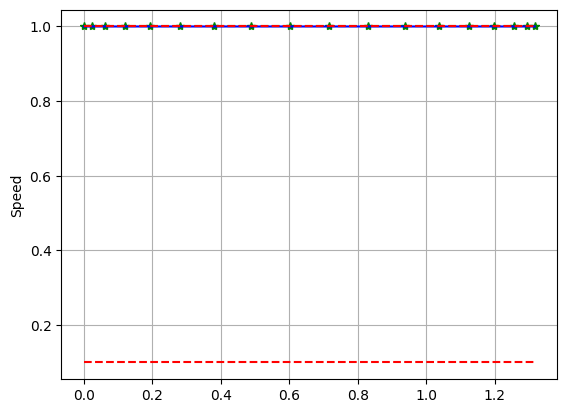

In [493]:
plt.plot(T*colloc_dist, v, '*g--')
plt.plot(T*eval_dist, colloc_to_eval@v, 'b-')
plt.plot([0,T], [vmax,vmax],'r--')
plt.plot([0,T], [vmin,vmin],'r--')
plt.grid('on')
plt.ylabel('Speed')
plt.show()

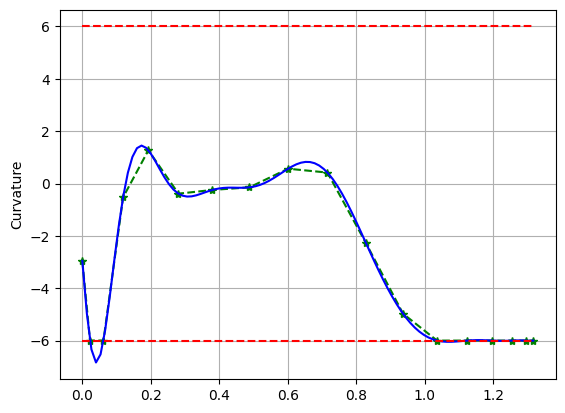

In [494]:
plt.plot(T*colloc_dist,k,'*g--')
plt.plot(T*eval_dist, colloc_to_eval@k, 'b-')
plt.plot([0,T], [kmax,kmax],'r--')
plt.plot([0,T], [-kmax,-kmax],'r--')
plt.grid('on')
plt.ylabel('Curvature')
plt.show()